## BarGenerator内容
1. 15分钟Bar更新
2. 60分钟Bar更新

## 策略逻辑：
60分钟看长短期MA趋势， 15分钟做均线择时。

## CtaTemplate 内的方法
BarGenerator(self.onBar, 60, self.on60MinBar): 从分钟self.onBar间隔60分钟输入self.on60MinBar

## 配置引擎回测

In [1]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy.ctaBarManager import CtaTemplate
import numpy as np
import talib as ta
from datetime import timedelta

########################################################################
# 策略继承CtaTemplate
class MultiFrameMaStrategy(CtaTemplate):
    className = 'MultiFrameMaStrategy'
    author = 'ChannelCMT'
    
    # 策略参数
    barPeriod = 100
    fastWindow = 30     # 快速均线参数
    slowWindow = 60     # 慢速均线参数

    
    # 策略变量
    fastMa0 =  {}   # 当前最新的快速EMA
    fastMa1 =  {}   # 上一根的快速EMA
    slowMa0 =  {}   # 当前最新的慢速EMA
    slowMa1 =  {}   # 上一根的慢速EMA
    maTrend = {}             # 均线趋势，多头1，空头-1
    
    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'vtSymbol',
                 'symbolList',
                 'barPeriod',
                 'fastWindow',
                 'slowWindow']    
    
    # 变量列表，保存了变量的名称
    varList = ['fastMa0',
               'fastMa1',
               'slowMa0',
               'slowMa1',
               'maTrend']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.setArrayManagerSize(self.barPeriod)
        self.fastMa0 = {s: 0 for s in self.symbolList}   # 当前最新的快速EMA
        self.fastMa1 = {s: 0 for s in self.symbolList}   # 上一根的快速EMA
        self.slowMa0 = {s: 0 for s in self.symbolList}   # 当前最新的慢速EMA
        self.slowMa1 = {s: 0 for s in self.symbolList}   # 上一根的慢速EMA
        self.maTrend = {s: 0 for s in self.symbolList}   # 均线趋势，多头1，空头-1
        self.mail("chushihuaaaaaaaaaaaaaaaaaaaaaaaaa")
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        symbol = bar.vtSymbol
        
    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """60分钟K线推送"""
        symbol = bar.vtSymbol
        
        am60 = self.getArrayManager(symbol, "60m")

        if not am60.inited:
            return
        
        # 计算均线并判断趋势
        fastMa = ta.MA(am60.close, self.fastWindow)
        slowMa = ta.MA(am60.close, self.slowWindow)
#         print(fastMa)
        
        if fastMa[-1] > slowMa[-1]:
            self.maTrend[symbol] = 1
        else:
            self.maTrend[symbol] = -1
        print('maTrend:',self.maTrend)
    
    #----------------------------------------------------------------------
    def on15MinBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        symbol = bar.vtSymbol
        
        am15 = self.getArrayManager(symbol, "15m")

        if not am15.inited:
            return

        fastMa = ta.EMA(am15.close, self.fastWindow)
        self.fastMa0[symbol] = fastMa[-1]
        self.fastMa1[symbol] = fastMa[-2]
        
        slowMa = ta.EMA(am15.close, self.slowWindow)
        self.slowMa0[symbol] = slowMa[-1]
        self.slowMa1[symbol] = slowMa[-2]

        # 判断买卖
        crossOver = self.fastMa0[symbol]>self.fastMa1[symbol] and self.slowMa0[symbol]>self.slowMa1[symbol]     # 均线上涨
        crossBelow = self.fastMa0[symbol]<self.fastMa1[symbol] and self.slowMa0[symbol]<self.slowMa1[symbol]    # 均线下跌
        print('crossOver:',crossOver)
        print('crossBelow:',crossBelow)        
        # 金叉和死叉的条件是互斥
        if crossOver and (self.maTrend[symbol]==1):
            # 如果金叉时手头没有持仓，则直接做多
            if (self.posDict[symbol+'_LONG']==0) and \
            (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol,bar.close, 1)
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] >0:
                self.cover(symbol,bar.close, self.posDict[symbol+'_SHORT'])
                self.buy(symbol,bar.close, 1)

        # 死叉和金叉相反
        elif crossBelow and (self.maTrend[symbol]==-1):
            if (self.posDict[symbol+'_LONG']==0) and \
            (self.posDict[symbol+'_SHORT']==0):
                self.short(symbol,bar.close, 1)
            elif self.posDict[symbol+'_LONG'] == 1:
                self.sell(symbol,bar.close, 1)
                self.short(symbol,bar.close, 1)

        
        # 发出状态更新事件
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
#         print(self.posDict)
        pass
    
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

## 查看绩效与优化

In [9]:
if __name__=="__main__":
    from vnpy.trader.app.ctaStrategy.ctaBarManager import BacktestingEngine
    from vnpy.trader.app.ctaStrategy.ctaBacktesting import OptimizationSetting, MINUTE_DB_NAME
    # 创建回测引擎对象
    engine = BacktestingEngine()
    # 设置回测使用的数据
    engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
    engine.setStartDate('20181001 12:00',initHours=94)               # 设置回测用的数据起始日期
    engine.setEndDate('20181030 12:00')
    # 配置回测引擎参数
    engine.setSlippage(0.1)     # 设置滑点
    engine.setRate(5/10000)   # 设置手续费万0.3
    engine.setSize(1)         # 设置合约大小
    engine.setPriceTick(0.01)    # 设置股指最小价格变动
    engine.setCapital(1000000)  # 设置回测本金

    # # 在引擎中创建策略对象
    d = {'symbolList':['BTCUSDT:binance']}          # 策略参数配置
    engine.initStrategy(MultiFrameMaStrategy, d)    # 创建策略对象
    engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x0000028E822BCA60>, <__main__.MultiFrameMaStrategy object at 0x0000028E897C1DD8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x0000028E822BCAE8>, <__main__.MultiFrameMaStrategy object at 0x0000028E897C1DD8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x0000028E822BCB70>, <__main__.MultiFrameMaStrategy object at 0x0000028E897C1DD8>)
2018-11-12 17:16:50.458436	开始回测
2018-11-12 17:16:50.458436	策略初始化
2018-11-12 17:16:50.460435	载入历史数据。数据范围:[20180927 14:00,20181001 12:00)
2018-11-12 17:16:51.508231	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-11-12 17:16:51.511229	载入完成，数据量：5640
2018-11-12 17:16:51.511229	策略初始化完成
2018-11-12 17:16:51.511229	策略启动完成
2018-11-12 17:16:51.511229	开始回放回测数据,回测范围:[20181001 12:00,201

crossOver: False:22.591459	Progress: 5%    
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: True
crossB

maTrend: {'BTCUSDT:binance': -1}ess: 12%    
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOve

crossOver: False:23.595653	Progress: 19%    
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBel

crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}ress: 26%    
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: Tr

crossOver: False:24.532250	Progress: 33%    
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:

crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True7:24.956201	Progress: 40%    
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:bi

crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True7:25.431229	Progress: 47%    
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: Tr

crossOver: False:25.939917	Progress: 54%    
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: 

maTrend: {'BTCUSDT:binance': -1}ess: 61%    
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOve

crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}ess: 68%    
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossO

crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False:27.438995	Progress: 75%    
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
cros

crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False:27.927695	Progress: 82%    
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: Tru

maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False:28.424389	Progress: 89%    
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow

maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
crossOver: True7:28.878109	Progress: 96%    
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBe

In [10]:
    import pandas as pd
    TradeDf = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])

In [11]:
    print(TradeDf.tail())

   direction                  dt exchange exchangeOrderID  fee gatewayName  \
6          空 2018-10-07 18:00:00                           0.0               
7          多 2018-10-08 23:15:00                           0.0               
8          多 2018-10-08 23:15:00                           0.0               
9          多 2018-10-09 02:29:00                           0.0               
10         多 2018-10-09 02:29:00                           0.0               

   offset orderID orderTime    price  price_avg rawData status symbol tradeID  \
6      开仓       7            6555.45        0.0    None                     7   
7      平仓      10            6667.00        0.0    None                     8   
8      开仓      11            6667.00        0.0    None                     9   
9      平仓       8            6659.03        0.0    None                    10   
10     开仓       9            6659.03        0.0    None                    11   

             tradeTime  volume vtOrderID    

2018-11-12 17:19:05.754858	计算按日统计结果
2018-11-12 17:19:05.790829	------------------------------
2018-11-12 17:19:05.791829	首个交易日：	2018-10-01 00:00:00
2018-11-12 17:19:05.791829	最后交易日：	2018-10-30 00:00:00
2018-11-12 17:19:05.791829	总交易日：	30
2018-11-12 17:19:05.791829	盈利交易日	10
2018-11-12 17:19:05.791829	亏损交易日：	20
2018-11-12 17:19:05.791829	起始资金：	1000000
2018-11-12 17:19:05.791829	结束资金：	998,886.07
2018-11-12 17:19:05.791829	总收益率：	-0.11%
2018-11-12 17:19:05.791829	年化收益：	-0.89%
2018-11-12 17:19:05.791829	总盈亏：	-1,113.93
2018-11-12 17:19:05.791829	最大回撤: 	-1,634.49
2018-11-12 17:19:05.791829	百分比最大回撤: -0.16%
2018-11-12 17:19:05.791829	总手续费：	36.39
2018-11-12 17:19:05.791829	总滑点：	1.1
2018-11-12 17:19:05.792828	总成交金额：	72,785.86
2018-11-12 17:19:05.792828	总成交笔数：	11
2018-11-12 17:19:05.792828	日均盈亏：	-37.13
2018-11-12 17:19:05.792828	日均手续费：	1.21
2018-11-12 17:19:05.792828	日均滑点：	0.04
2018-11-12 17:19:05.792828	日均成交金额：	2,426.2
2018-11-12 17:19:05.792828	日均成交笔数：	0.37
2018-11-12 17:19:05.792828	日均收益率：	-0.0%

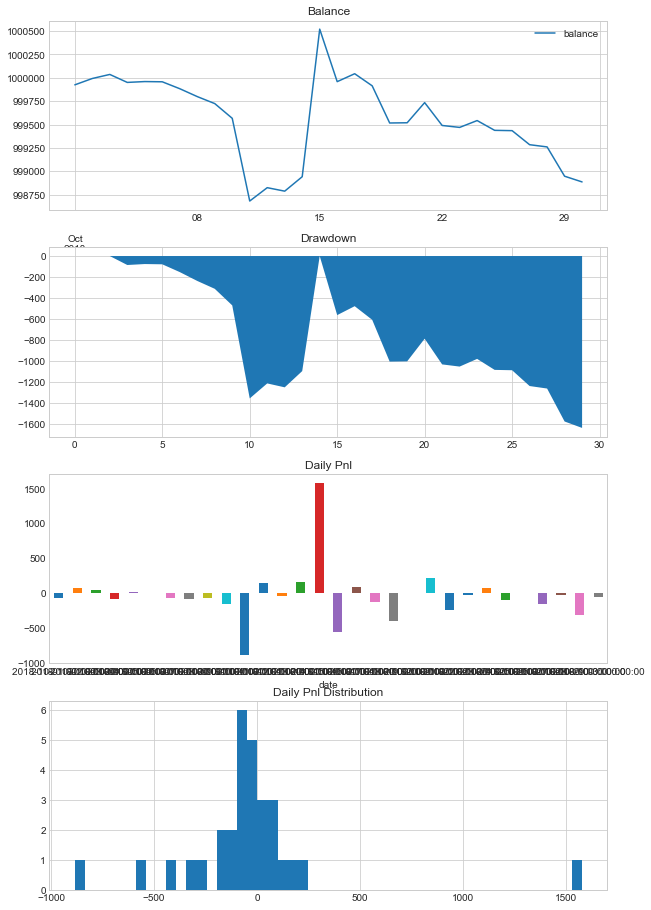

2018-11-12 17:19:06.865177	计算回测结果
2018-11-12 17:19:06.866173	------------------------------
2018-11-12 17:19:06.866173	第一笔交易：	2018-10-02 16:45:00
2018-11-12 17:19:06.866173	最后一笔交易：	2018-10-30 11:58:00
2018-11-12 17:19:06.867172	总交易次数：	7
2018-11-12 17:19:06.867172	总盈亏：	-1,123.78
2018-11-12 17:19:06.867172	最大回撤: 	-1,123.78
2018-11-12 17:19:06.867172	平均每笔盈利：	-160.54
2018-11-12 17:19:06.867172	平均每笔滑点：	0.2
2018-11-12 17:19:06.867172	平均每笔佣金：	6.56
2018-11-12 17:19:06.867172	胜率		14.29%
2018-11-12 17:19:06.867172	盈利交易平均值	3.26
2018-11-12 17:19:06.867172	亏损交易平均值	-187.84
2018-11-12 17:19:06.867172	盈亏比：	0.02
2018-11-12 17:19:06.991108	交易记录没有达到10笔！


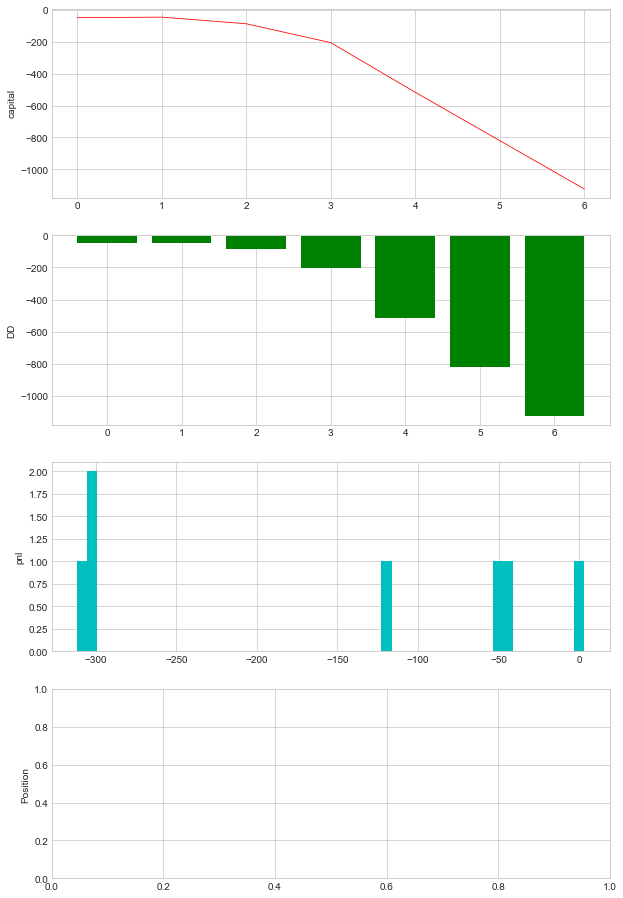

In [12]:
# 显示逐日回测结果
engine.showDailyResult()
# 显示逐笔回测结果
engine.showBacktestingResult()

In [13]:
PerfromanceDf = engine.calculateDailyResult()

2018-11-12 17:19:24.534316	计算按日统计结果


In [14]:
# PerfromanceDf.to_excel('perfromanceMultiFrameMa.xlsx')

In [15]:
df1, result = engine.calculateDailyStatistics(PerfromanceDf)

In [16]:
result

{'startDate': Timestamp('2018-10-01 00:00:00'),
 'endDate': Timestamp('2018-10-30 00:00:00'),
 'totalDays': 30,
 'profitDays': 10,
 'lossDays': 20,
 'endBalance': 998886.06707,
 'maxDrawdown': -1634.4899999999907,
 'maxDdPercent': -0.16336395973577542,
 'totalNetPnl': -1113.9329299999977,
 'dailyNetPnl': -37.13109766666659,
 'totalCommission': 36.39293,
 'dailyCommission': 1.2130976666666666,
 'totalSlippage': 1.1,
 'dailySlippage': 0.03666666666666667,
 'totalTurnover': 72785.86,
 'dailyTurnover': 2426.1953333333336,
 'totalTradeCount': 11,
 'dailyTradeCount': 0.36666666666666664,
 'totalReturn': -0.11139329300000611,
 'annualizedReturn': -0.8911463440000489,
 'dailyReturn': -0.003463699995324513,
 'returnStd': 0.03755654232172581,
 'sharpeRatio': -1.4287633066146548}

In [17]:
# 优化配置
setting = OptimizationSetting()                # 新建一个优化任务设置对象
setting.setOptimizeTarget('totalNetPnl')        # 设置优化排序的目标是策略净盈利
setting.addParameter('fastWindow', 30, 51, 10)    # 增加第一个优化参数fastWindow，起始30，结束51，步进10
setting.addParameter('slowWindow', 70, 91, 10)        # 增加第二个优化参数slowWindow，起始70，结束91，步进10
setting.addParameter('symbolList', ['BTCUSDT:binance']) 
#setting.addParameter('rsiLength', 5)            # 增加一个固定数值的参数

# 执行多进程优化
import time
start = time.time()
# resultList = engine.runParallelOptimization(MultiFrameMaStrategy, setting)
resultList = engine.runOptimization(MultiFrameMaStrategy, setting)
print('耗时：%s' %(time.time()-start))

2018-11-12 17:19:33.544624	------------------------------
2018-11-12 17:19:33.545616	setting: {'fastWindow': 30, 'slowWindow': 70, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x0000028E822BCA60>, <__main__.MultiFrameMaStrategy object at 0x0000028E84AAC5C0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x0000028E822BCAE8>, <__main__.MultiFrameMaStrategy object at 0x0000028E84AAC5C0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x0000028E822BCB70>, <__main__.MultiFrameMaStrategy object at 0x0000028E84AAC5C0>)
2018-11-12 17:19:33.546615	开始回测
2018-11-12 17:19:33.546615	策略初始化
2018-11-12 17:19:33.547615	载入历史数据。数据范围:[20180927 14:00,20181001 12:00)
2018-11-12 17:19:34.621126	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018

crossOver: False:05.576009	Progress: 5%    
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: True
cross

maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}ess: 12%    
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossO

crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False:06.468458	Progress: 19%    
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBe

maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}ress: 26%    
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: 

crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False:07.471841	Progress: 33%    
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver:

crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True0:07.966536	Progress: 40%    
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
cros

crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True0:08.449239	Progress: 47%    
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 

maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False:08.904960	Progress: 54%    
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: T

crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}ess: 61%    
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOv

maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}ess: 68%    
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
cross

crossOver: False:10.320091	Progress: 75%    
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:

crossOver: False:10.773810	Progress: 82%    
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: Tru

crossOver: False:11.211542	Progress: 89%    
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:bina

crossOver: True0:11.680251	Progress: 96%    
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossB

maTrend: {'BTCUSDT:binance': 1}ress: 1%    
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: Fa

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False:44.642737	Progress: 8%    
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: 

crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True0:45.112448	Progress: 15%    
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance'

crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False:45.621136	Progress: 22%    
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: False
cr

crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False:46.119831	Progress: 29%    
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 

crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}ess: 36%    
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
c

crossOver: False:47.035271	Progress: 43%    
crossBelow: True
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossB

crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}ress: 50%    
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
cro

crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False:47.958700	Progress: 57%    
crossBelow: True
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: Fa

crossOver: False:48.431409	Progress: 64%    
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binanc

crossOver: False:48.887128	Progress: 71%    
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
cr

maTrend: {'BTCUSDT:binance': -1}ess: 78%    
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
cross

crossOver: False:49.787574	Progress: 85%    
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBe

maTrend: {'BTCUSDT:binance': -1}ess: 92%    
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True

crossOver: False:50.706013	Progress: 99%    
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:

crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False:23.494353	Progress: 4%    
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBe

crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: True1:23.962105	Progress: 11%    
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBel

crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False:24.441811	Progress: 18%    
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelo

maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}ess: 25%    
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
c

crossOver: False:25.411090	Progress: 32%    
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
cr

crossOver: False:25.930770	Progress: 39%    
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True


crossOver: False:26.426465	Progress: 46%    
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCU

crossOver: False
crossBelow: True
crossOver: False:26.947145	Progress: 53%    
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow

crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}ress: 60%    
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: 

maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}ess: 67%    
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelo

crossOver: False:28.380389	Progress: 74%    
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow

crossOver: False:28.857096	Progress: 81%    
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: Fal

maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True1:29.315811	Progress: 88%    
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: True
crossBel

crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: 17:21:29.781525	Progress: 95%     False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
cro

2018-11-12 17:21:39.788900	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-11-12 17:21:39.790899	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20181001102000 , 20181001120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪
2018-11-12 17:21:39.805893	载入历史数据。数据范围:[20180922 00:45,20181003 12:15)
2018-11-12 17:21:42.968034	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-11-12 17:21:42.977031	载入完成，数据量：16530
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180930110000 , 20181001120000]
[INFO] 品种BTCUSDT:binance的15mK线准备就绪
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
2018-11-12 17:21:44.937825	载入历史数据。数据范围:[20180824 15:00,20181003 13:00)
2018-11-12 17:21:55.648686	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-11-12 17:21:55.682667	载入完成，数据量：57480
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180927080000 , 20181001120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
cr

crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False:01.980449	Progress: 7%    
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow

crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}ress: 14%    
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: Fa

crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False:02.954480	Progress: 21%    
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: 

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False:03.460169	Progress: 28%    
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCU

crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False:03.955527	Progress: 35%    
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelo

maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
crossOver: True2:04.445224	Progress: 42%    
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelo

crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}ress: 49%    
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: T

crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False:05.423711

crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False:05.917407	Progress: 63%    
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:bina

maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True2:06.414101	Progress: 70%    
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBel

crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False:06.906863	Progress: 77%    
crossBelo

crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
cro

maTrend: {'BTCUSDT:binance': -1}ess: 90%    
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOv

crossOver: True2:08.174557	Progress: 97%    
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBel

maTrend: {'BTCUSDT:binance': 1}ress: 2%    
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossO

crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: False:40.918333	Progress: 9%    
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: True
crossBelow

crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False:41.386043	Progress: 16%    
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: Fal

crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True2:41.865750	Progress: 23%    
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:bi

crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True2:42.321470	Progress: 30%    
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSD

crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}ess: 37%    
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOve

maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False:43.231424	Progress: 44%    
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
cross

crossOver: False:43.699605	Progress: 51%    
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBel

maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False:44.171312	Progress: 58%    
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBe

crossOver: False:44.627703	Progress: 65%    
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUS

maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False:45.080427	Progress: 72%    
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: Fal

crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}ess: 79%    
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOve

maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False:45.997868	Progress: 86%    
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBe

crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False:46.452583	Progress: 93%    
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False

crossOver: False:46.906304	Progress: 100%    
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
2018-11-12 17:22:46.915298	数据回放结束
2018-11-12 17:22:46.915298	计算按日统计结果
2018-11-12 17:22:46.983256	------------------------------
2018-11-12 17:22:46.983256	setting: {'fastWindow': 40, 'slowWindow': 90, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x0000028E822BCA60>, <__main__.MultiFrameMaStrategy object at 0x0000028E82FF0BE0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x0000028E822BCAE8>, <__main__.MultiFrameMaStrategy object at 0x0000028E82FF0BE0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x0000028E822BCB70>, <__main__.MultiFrameMaStrategy object at 0x0000028E82FF0BE0>)


maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False:19.198139	Progress: 5%    
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True

crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}ess: 12%    
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False


crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False:20.158548	Progress: 19%    
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance'

crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}ress: 26%    
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: 

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False:21.149937	Progress: 33%    
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
cross

crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True3:21.643632	Progress: 40%    
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
c

crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True3:22.123339	Progress: 47%    
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 

crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False:22.611039	Progress: 54%    
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance':

crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}ess: 61%    
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOve

crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}ess: 68%    
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossO

crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False:24.081133	Progress: 75%    
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: True
c

maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False:24.540852	Progress: 82%    
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelo

crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False:24.940606	Progress: 89%    
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelo

crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
crossOver: True3:25.385332	Progress: 96%    
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUS

maTrend: {'BTCUSDT:binance': 1}ress: 1%    
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: Tru

crossOver: False:58.216334	Progress: 8%    
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
cros

crossOver: True3:58.690042	Progress: 15%    
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: T

crossOver: False:59.175745	Progress: 22%    
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance'

crossOver: False:59.661446	Progress: 29%    
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: True
crossBelow: Fa

maTrend: {'BTCUSDT:binance': -1}ess: 36%    
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOve

crossOver: False:00.638843	Progress: 43%    
crossBelow: True
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelo

crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}ress: 50%    
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver

crossOver: False:01.679204	Progress: 57%    
crossBelow: True
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 

crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False:02.172901	Progress: 64%    
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelo

crossOver: False
crossBelow: False
crossOver: True4:02.663597	Progress: 71%    
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False


maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}ess: 78%    
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOv

crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True4:03.644995	Progress: 85%    
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binan

maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}ess: 92%    
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOv

maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False:04.633384	Progress: 99%    
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelo

crossOver: False:36.665175	Progress: 4%    
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: Tr

crossOver: True4:37.070925	Progress: 11%    
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:

crossOver: True4:37.589608	Progress: 18%    
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: T

maTrend: {'BTCUSDT:binance': -1}ess: 25%    
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOv

crossOver: False:38.597991	Progress: 32%    
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBel

crossOver: True4:39.083687	Progress: 39%    
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossB

crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: True4:39.577384	Progress: 46%    
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossB

crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False:40.068082	Progress: 53%    
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance':

crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}ess: 60%    
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOve

crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}ess: 67%    
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: Fal

maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False:41.544174	Progress: 74%    
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: Tru

crossOver: False
crossBelow: False
crossOver: False:42.041866	Progress: 81%    
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: Fal

crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True4:42.532566	Progress: 88%    
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:bin

crossOver: False
crossBelow: True
crossOver: False:43.029260	Progress: 95%    
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelo

2018-11-12 17:24:56.163891	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-11-12 17:24:56.173891	载入完成，数据量：16530
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180930110000 , 20181001120000]
[INFO] 品种BTCUSDT:binance的15mK线准备就绪
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
2018-11-12 17:24:58.209520	载入历史数据。数据范围:[20180824 15:00,20181003 13:00)
2018-11-12 17:25:09.013828	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-11-12 17:25:09.047835	载入完成，数据量：57480
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180927080000 , 20181001120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow

crossOver: False:16.243032	Progress: 7%    
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow

maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}ess: 14%    
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOve

crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False:17.144819	Progress: 21%    
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: Tr

crossOver: False:17.608534	Progress: 28%    
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow

crossOver: False:18.068251	Progress: 35%    
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binanc

maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
crossOver: True5:18.525969	Progress: 42%    
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelo

maTrend: {'BTCUSDT:binance': 1}ress: 49%    
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: Tr

crossOver: False:19.451580	Progress: 56%    
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: Tr

crossOver: False:19.918296	Progress: 63%    
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binanc

crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True5:20.374015	Progress: 70%    
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binan

crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False:20.836728	Progress: 77%    
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': 1}
crossOver: False
crossBelow: True
crossOver: False
crossBelo

maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False:21.299046	Progress: 84%    
crossBelow: True
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: True
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
c

crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}ess: 91%    
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOve

crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False:22.205489	Progress: 98%    
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binance': -1}
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
maTrend: {'BTCUSDT:binanc

In [18]:
resultList

[(["{'fastWindow': 50, 'slowWindow': 70, 'symbolList': ['BTCUSDT:binance']}"],
  488.4989400000016,
  {'startDate': Timestamp('2018-10-01 00:00:00'),
   'endDate': Timestamp('2018-10-30 00:00:00'),
   'totalDays': 30,
   'profitDays': 13,
   'lossDays': 16,
   'endBalance': 1000488.49894,
   'maxDrawdown': -329.3996299999999,
   'maxDdPercent': -0.0329384257636696,
   'totalNetPnl': 488.4989400000016,
   'dailyNetPnl': 16.283298000000052,
   'totalCommission': 82.28106000000001,
   'dailyCommission': 2.7427020000000004,
   'totalSlippage': 2.5,
   'dailySlippage': 0.08333333333333333,
   'totalTurnover': 164562.12000000002,
   'dailyTurnover': 5485.404,
   'totalTradeCount': 25,
   'dailyTradeCount': 0.8333333333333334,
   'totalReturn': 0.048849894000002614,
   'annualizedReturn': 0.3907991520000209,
   'dailyReturn': 0.0014723691741558298,
   'returnStd': 0.012951241926386551,
   'sharpeRatio': 1.7612091020727945}),
 (["{'fastWindow': 40, 'slowWindow': 80, 'symbolList': ['BTCUSDT:bin

In [19]:
import pandas as pd

print(pd.DataFrame(resultList).sort_values(1,  ascending=False).iloc[0:5])

                                                   0          1  \
0  [{'fastWindow': 50, 'slowWindow': 70, 'symbolL...  488.49894   
1  [{'fastWindow': 40, 'slowWindow': 80, 'symbolL...  458.20734   
2  [{'fastWindow': 40, 'slowWindow': 70, 'symbolL...  427.66086   
3  [{'fastWindow': 40, 'slowWindow': 90, 'symbolL...  347.51745   
4  [{'fastWindow': 50, 'slowWindow': 90, 'symbolL...   30.14712   

                                                   2  
0  {'startDate': 2018-10-01 00:00:00, 'endDate': ...  
1  {'startDate': 2018-10-01 00:00:00, 'endDate': ...  
2  {'startDate': 2018-10-01 00:00:00, 'endDate': ...  
3  {'startDate': 2018-10-01 00:00:00, 'endDate': ...  
4  {'startDate': 2018-10-01 00:00:00, 'endDate': ...  


In [20]:
# 显示优化的所有统计数据
for result in resultList:
    print('-' * 30)
    print('参数：%s，目标：%s' %(result[0], result[1]))
    print('统计数据：')
    for k, v in result[2].items():
        print('%s：%s' %(k, v))

------------------------------
参数：["{'fastWindow': 50, 'slowWindow': 70, 'symbolList': ['BTCUSDT:binance']}"]，目标：488.4989400000016
统计数据：
startDate：2018-10-01 00:00:00
endDate：2018-10-30 00:00:00
totalDays：30
profitDays：13
lossDays：16
endBalance：1000488.49894
maxDrawdown：-329.3996299999999
maxDdPercent：-0.0329384257636696
totalNetPnl：488.4989400000016
dailyNetPnl：16.283298000000052
totalCommission：82.28106000000001
dailyCommission：2.7427020000000004
totalSlippage：2.5
dailySlippage：0.08333333333333333
totalTurnover：164562.12000000002
dailyTurnover：5485.404
totalTradeCount：25
dailyTradeCount：0.8333333333333334
totalReturn：0.048849894000002614
annualizedReturn：0.3907991520000209
dailyReturn：0.0014723691741558298
returnStd：0.012951241926386551
sharpeRatio：1.7612091020727945
------------------------------
参数：["{'fastWindow': 40, 'slowWindow': 80, 'symbolList': ['BTCUSDT:binance']}"]，目标：458.2073399999999
统计数据：
startDate：2018-10-01 00:00:00
endDate：2018-10-30 00:00:00
totalDays：30
profitDays：1